In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers
import seaborn as sns

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX, Normalizer

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
flow = ResFlow(2, 'res_init', normalize=False)(inp)
# flow = NVPFlow(name='nvp_init', normalize=True)(flow)

for i in range(0, 9):
    flow = ResFlow(name='res_' + str(i), normalize=False)(flow)
#     flow = NVPFlow(name='nvp_' + str(i), normalize=True)(flow)

In [5]:
flow[-1].output /= 2

In [6]:
flow[-1].logj.shape

TensorShape([Dimension(None)])

In [7]:
flows = flow

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_10:0' shape=(?,) dtype=float64>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask
        print(fl.mask)

[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]


In [11]:
mm

array([5, 5])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
lr = tf.Variable(0.001, trainable=False, name='learning_rate')
train_op = tf.train.AdamOptimizer(lr).minimize(-gain)
train_op = [train_op] + flows.get_ops()

In [14]:
X, _ = make_moons(n_samples=4024, noise=0.13)

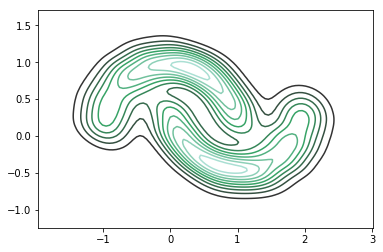

In [15]:
sns.kdeplot(X[:,0], X[:,1], kernel='tri')
plt.show()

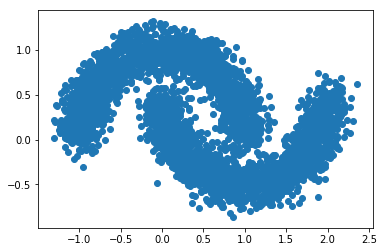

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-6.93388426143101

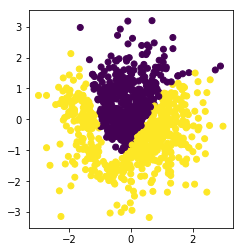

In [65]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X, phase:False})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [31]:
sess.run(lr.assign(0.0001))

1e-04

In [21]:
!rm -R /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [22]:
writer.add_graph(tf.get_default_graph())

In [23]:
all_sum = tf.summary.merge_all()

In [64]:
for _ in range(80):
    for _ in range(300):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X, phase:True})
    print(gain.eval({inp:X, phase: True}))
    #writer.add_summary(all_sum.eval({inp:X, phase:True}))

-5.083395117677753
-5.06561433290217
-5.000697959248377
-5.111368845413898
-5.050453147004429
-5.024556841310799
-5.006743243170694
-5.013017128368115
-5.095205107620474
-5.059210180263023
-5.066027684187279
-5.029828331091531
-5.039665766950255
-5.0210873620720875
-5.045529501488053
-5.073150955577887
-5.065255534955574


KeyboardInterrupt: 

In [26]:
inverse = flows.apply(inp*2, inverse=True)

In [66]:
restored = inverse.eval({inp:np.random.normal(size=[1000,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [67]:
restored = restored[np.logical_not(np.any(restored**2 > 30, axis=-1))]

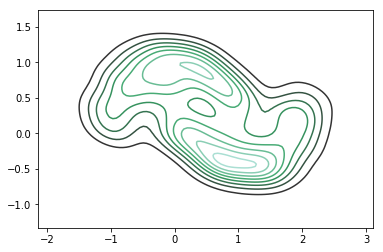

In [68]:
sns.kdeplot(restored[:,0], restored[:,1])
plt.show()

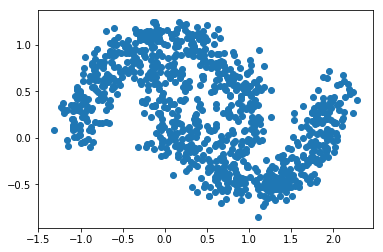

In [69]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()

In [32]:
flows.ops

[]